# **Homework 5 - ADM - Group #3**

## **Useful libraries**

In [57]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from heapq import heapify, heappush, heappop
from IPython.display import Image
from IPython.core.display import HTML 

## **1. Data**

Let's start by loading the three datasets that we are going to work with.

In [2]:
df_hero = pd.read_csv("hero-network.csv")

In [3]:
df_hero.head(5)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [4]:
df_nodes = pd.read_csv("nodes.csv")

In [5]:
df_nodes.head(5)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


In [6]:
df_edges = pd.read_csv("edges.csv")

In [7]:
df_edges.head(5)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


### Preprocessing

Now it's the time to adjust and clean our datasets.<br>
As we can see below some heroes' name contain white spaces or slashes at the end. 

In [8]:
df_hero.tail(5)

,hero1,hero2
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /
574466,HULK/DR. ROBERT BRUC,"MARKS, DR. SHIELA"


So we are going to delete the white spaces or slashes that can be present at the end of the names of the heroes.

In [9]:
df_hero["hero1"] = df_hero["hero1"].apply(lambda x: x.strip('/'))
df_hero["hero2"] = df_hero["hero2"].apply(lambda x: x.strip('/'))
df_hero["hero1"] = df_hero["hero1"].apply(lambda x: x.strip())
df_hero["hero2"] = df_hero["hero2"].apply(lambda x: x.strip())

In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x.strip('/'))
df_edges["hero"] = df_edges["hero"].apply(lambda x: x.strip())

In [11]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x.strip('/'))
df_nodes["node"] = df_nodes["node"].apply(lambda x: x.strip())

In [12]:
df_hero.tail(5)

,hero1,hero2
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE
574466,HULK/DR. ROBERT BRUC,"MARKS, DR. SHIELA"


Now, we know that in the "hero-network.csv" dataset the names of the heroes are limited to 20 characters, so to have all datasets consistent, we cut all the heroes' names to 20 characters.

In [13]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[:20])

In [14]:
df_edges.loc[75723]

hero     SPIDER-MAN/PETER PAR
comic                   A 118
Name: 75723, dtype: object

Finallly, we remove form the "hero-network.csv" the couples that have the same hero in the two columns, because this would form a self loop in the graph and we are not interested in those.

In [15]:
df_hero_noduplicate = df_hero[df_hero.hero1 != df_hero.hero2].copy(deep=True)

In [16]:
df_hero_noduplicate.shape

(572235, 2)

In [17]:
df_hero.shape

(574467, 2)

In [18]:
#save the cleaned datasets in pickle format
df_edges.to_pickle("edges_clear.pkl")
df_hero_noduplicate.to_pickle("hero_clear.pkl")
df_nodes.to_pickle('nodes_clear.pkl')

In [6]:
#run if you need to load the cleaned datasets
df_hero_noduplicate = pd.read_pickle("hero_clear.pkl")
df_edges = pd.read_pickle("edges_clear.pkl")
df_nodes = pd.read_pickle("nodes_clear.pkl")

### Graphs setup

### *Graph 1*
The metric that we decided to use for the weighting of the graph is $\frac{1}{number of collaborations}$, in this way the more collaborations two heroes have, the less the cost. <br>
Now, to do so let's start by constructing a multigraph, that is a graph that can contain multiple edges between the same couple of nodes.

In [7]:
#initialize a Multigraph
Graph_1 = nx.MultiGraph()

#get all the heroes
list(set((df_hero_noduplicate.hero1).unique()).union(set((df_hero_noduplicate.hero2).unique())))

#add the heroes as nodes of the graph
Graph_1.add_nodes_from(list(set((df_hero_noduplicate.hero1).unique()).union(set((df_hero_noduplicate.hero2).unique()))))

#add the collaborations between the heroes as edges
Graph_1.add_edges_from(list(zip(list(df_hero_noduplicate.hero1),list(df_hero_noduplicate.hero2))))

nx.info(Graph_1)

C:\Users\Angelo\AppData\Local\Temp/ipykernel_9492/2430691300.py:13: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(Graph_1)


'MultiGraph with 6421 nodes and 572235 edges'

Obtained the MultiGraph, we create the weighted Graph requested in this way: we iterate on all the edges of the multigraph, and for each couple we count the number of edges (assigning this number to the weight of the edge in the Graph). At this point we simply invert the weights to obtain new weights that follow our metric.

In [8]:
# create weighted graph from Graph_1
Graph_1reduce = nx.Graph()
#iterate on all the edges of the multigraph
for u,v,w in Graph_1.edges:
    if Graph_1reduce.has_edge(u,v):
        Graph_1reduce[u][v]['weight'] += 1
    else:
        Graph_1reduce.add_edge(u, v, weight=1)
        
#invert the weights of the graph
for u,v in Graph_1reduce.edges:
    Graph_1reduce[u][v]['weight']=1/Graph_1reduce[u][v]['weight']

In [5]:
#example
Graph_1reduce.edges()[('PRINCESS ZANDA', 'LITTLE, ABNER')]['weight']

0.125

### *Graph 2*
In this case we simply have to create a graph with heroes and comics as nodes, there is and edge between a hero and a comic only if the hero has appered in that comic.

In [34]:
df_nodes[df_nodes.type=='comic'].node

0             2001 10
1              2001 8
2              2001 9
7               A '00
8               A '01
             ...     
19021    YOUNG MEN 24
19022    YOUNG MEN 25
19023    YOUNG MEN 26
19024    YOUNG MEN 27
19025    YOUNG MEN 28
Name: node, Length: 12651, dtype: object

In [5]:
set(df_nodes[df_nodes.type=='hero'].node)

In [9]:
#initialize an undirected Graph
Graph_2 = nx.Graph()

#add heroes and comics as nodes
Graph_2.add_nodes_from(list((df_nodes.node).unique()))

#add an edge between a hero and a comic if the hero appears in that comic
Graph_2.add_edges_from(list(zip(list(df_edges.hero),list(df_edges.comic))))

nx.info(Graph_2)

C:\Users\Angelo\AppData\Local\Temp/ipykernel_9492/533129435.py:10: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(Graph_2)


'Graph with 19089 nodes and 96104 edges'

## **2. Backend Implementation**

As requested, to reduce computation time and improve network visualization, we wil consider the data for only top N heros. We define the top N heroes as the heroes who have appeared in the most number of comics.

In [10]:
def Top_N_heroes(N,df_edges):
    degree_nodes = df_edges.groupby('hero').size().reset_index()
    degree_nodes.rename(columns={0: "size"},inplace=True)
    first_N_heroes = list((degree_nodes.sort_values(by="size",ascending=False).head(N).hero))
    return(first_N_heroes)

To simplify the code in the functionalities below we can also define some functions to build the subgraphs

In [11]:
top = ['INVISIBLE WOMAN/SUE']
a = df_edges.hero.apply(lambda h: any([i in h for i in top]))
df_edges[a]

,hero,comic
37129,INVISIBLE WOMAN/SUE,A 1
37130,INVISIBLE WOMAN/SUE,A 12
37131,INVISIBLE WOMAN/SUE,A 127
37132,INVISIBLE WOMAN/SUE,A 128
37133,INVISIBLE WOMAN/SUE,A 13
...,...,...
37886,INVISIBLE WOMAN/SUE,X 71
37887,INVISIBLE WOMAN/SUE,XF 5
37888,INVISIBLE WOMAN/SUE,X:HY 20
37889,INVISIBLE WOMAN/SUE,X:HY 9


In [9]:

len(set(Graph_2.nodes).intersection(set(df_nodes[df_nodes.type=='comic'].node)))

12651

In [12]:
def get_subgraph_1(graph_data, top_N_heroes):
    #take the subgraph with only the top N heroes as nodes
    graph = Graph_1reduce.subgraph(top_N_heroes)
    return graph


def get_subgraph_2(graph_data, top_N_heroes):
    #get the position of the comics in which at least one of the top N heroes is present
    pos = graph_data.hero.apply(lambda h: any([i in h for i in top_N_heroes]))
    #get the names of those comics
    top_comics = graph_data[pos].comic
    #take the subgraph
    graph = Graph_2.subgraph(list(top_N_heroes) + list(top_comics))
    return graph

### Functionality 1 - extract the graph's features
Input: 
* The graph data
* The graph type (ex., number 1 or number 2)
* N: denoting the top N heroes that their data should be considered

Output:
* The number of nodes in the network (if type 2, report for both node types)
* The number of collaborations of each superhero with the others (only if type 1)
* The number of heroes that have appeared in each comic (only if type 2)
* The network's density
* The network's degree distribution
* The average degree of the network
* The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
* Whether the Network is sparse or dense

Depending on the graph that we are considering, we are interested in different features, so we implemented two different functions at support of the requested one.


In [13]:
def features_type_1(graph):
    '''
    Function that returns the features of interest for the graphs of type 1
    '''
    
    #get the number of nodes in the graph
    n_nodes = graph.number_of_nodes()
    
    #get the number of collaborations of each hero with the others
    collaborations = {}
    for hero in graph.nodes:
        collaborations[hero] = sum([1/graph[u][v]['weight'] for u,v in graph.edges(hero)])
        
    #get the density of the graph
    density = (2*len(graph.edges))/((n_nodes)*(n_nodes-1))
    
    #get the degrees of the nodes (useful for the degree distribution)
    degrees = [graph.degree(n) for n in graph.nodes()]
    
    #average degree
    average_degree = sum(degrees)/n_nodes
    
    #get hubs
    #1. get the 95th percentile
    p = np.percentile(np.array(degrees), 95)
    hubs = []
    for n in graph.nodes:
        if graph.degree(n) > p:
            hubs.append(n)        
            
    #dense / sparse network
    is_dense = density > 0.9
    
    return [n_nodes, collaborations, density, degrees, average_degree, hubs, is_dense]

In [14]:
def features_type_2(graph, top_N_heroes):
    '''
    Function that returns the features of interest for the graphs of type 2
    '''
    #comic nodes
    comics = set(graph.nodes).intersection(set(df_nodes[df_nodes.type=='comic'].node))
    #hero-nodes
    #heroes = set(graph.nodes).intersection(set(df_nodes[df_nodes.type=='hero'].node))
    heroes = top_N_heroes
    
    #get number of comic nodes
    n_comics = len(comics)
    #get number of hero nodes
    n_heroes = len(heroes)
    
    #get the number of heroes per comic
    appearances = {}
    for comic in comics:
        count = 0
        for u,v in graph.edges(comic):
            if v in heroes:
                count += 1
        appearances[comic] = count
        
        
    #get the density of the graph
    density = (2*len(graph.edges))/((n_comics+n_heroes)*(n_comics+n_heroes-1))
    
    #get the degrees of the nodes (useful for the degree distribution)
    degrees = [graph.degree(n) for n in graph.nodes()]
    
    #average degree
    average_degree = sum(degrees)/(n_comics + n_heroes)
    
    #get hubs
    #1. get the 95th percentile
    p = np.percentile(np.array(degrees), 95)
    hubs = []
    for n in graph.nodes:
        if graph.degree(n) > p:
            hubs.append(n)
            
    #dense / sparse network
    is_dense = density > 0.9
    
    return [{'comics': n_comics, 'heroes': n_heroes}, appearances, density, degrees, average_degree, hubs, is_dense]

In [15]:
def graph_features(graph_data, type_graph, N):
    
    #get the heroes-nodes to consider
    top_N_heroes = Top_N_heroes(N, df_edges)
    
    if(type_graph==1):
        graph = get_subgraph_1(graph_data, top_N_heroes)
        return features_type_1(graph)
    else:
        graph = get_subgraph_2(graph_data, top_N_heroes)
        return features_type_2(graph, top_N_heroes)
    

### Functionality 3 - Shortest ordered Route
Input:

* The graph data
* A sequence of superheroes h = [h_2, ..., h_n-1]
* Initial node h_1 and an end node h_n
* N: denoting the top N heroes that their data should be considered

Output:
* The shortest walk of comics that you need to read to get from hero_1 to hero_n 

Considerations: For this functionality, you need to implement an algorithm that returns the shortest walk that goes from node h_j to h_n, which\
 visits in order the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also\
 define it in any other way)

Important Notes:

* This algorithm should be run only on the second graph.
* The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such \
a scenario, it is enough to let the program give in the output the string "There is no such path".
* Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from\
 Spiderman to reach deadpool, and your path requires you to visit iron-man and colossus, you can go back to any comics any time you \
 want, assuming that the order in which you visit the heroes is still the same.

In [16]:
def dijkstra(G, init, end):
    # Initialize distances and predecessors
    dist = {vertex: float('inf') for vertex in G}
    prev = {vertex: None for vertex in G}
    dist[init] = 0

    Queue = []
    for vertex in G:
        Queue.append((dist[vertex], vertex))
    heapify(Queue)

    # Loop until the priority queue is empty
    while Queue:
        # Extract the vertex with the smallest distance
        u = heappop(Queue)[1]

        # Update the distances of the neighbors
        for v,null in G[u].items():
            alt = dist[u] 
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                # Update the priority queue
                Queue = [(dist[vertex], vertex) for vertex in G]
                heapify(Queue)

    # Construct the shortest path
    path = []
    u = end
    while prev[u]:
        path.append(u)
        u = prev[u]
    path.append(init)
    return path[::-1]

In [17]:
def Shortest_Path_Comics(graph_data,seq_heroes,init_nodo,end_node,N):
    Shortest_OR = [init_nodo]
    first_N_heroes = Top_N_heroes(N,graph_data)
    New_dataset = df_edges[df_edges['hero'].isin(first_N_heroes)]
    Graph_3 = nx.Graph()
    Graph_3.add_edges_from(list(zip(list(New_dataset.hero),list(New_dataset.comic))))
    seq_heroes=[init_nodo]+seq_heroes+[end_node]
    for i in range(1,len(seq_heroes)):
        if((Graph_3.has_node(seq_heroes[i-1])) & (Graph_3.has_node(seq_heroes[i]))):
            Shortest_OR += dijkstra(Graph_3,seq_heroes[i-1],seq_heroes[i])[1:]
            #[Graph_3_copy.remove_nodes_from(Shortest_OR[:-1])
        else:
            print("There is no such path.")
            break
    return(Shortest_OR,Graph_3)


### Functionality 4 - Disconnecting Graphs
Input: 
* The graph data
* heroA: a superhero to which will relate sub-graph G_a
* heroB: a superhero to which will relate sub-graph G_b
* N: denoting the top N heroes that their data should be considered

Output:
* The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

In [15]:
def disconnect_graph(graph_data, heroA, heroB, N):
    
    #get the heroes-nodes to consider
    top_N_heroes = Top_N_heroes(N, df_edges)
    
    if (heroA not in top_N_heroes) or (heroB not in top_N_heroes):
        raise ValueError("The two heroes are not present in the graph")
    
    original = get_subgraph_1(graph_data, top_N_heroes)
    modified = nx.Graph(original)
    
    count = 0
    while nx.has_path(modified, heroA, heroB):
        path = nx.shortest_path(modified, heroA, heroB)
        weights = [modified[path[i]][path[i+1]]['weight'] for i,node in enumerate(path[:-1])]
        min_value = min(weights)
        min_idx = weights.index(min_value)
        modified.remove_edge(path[min_idx], path[min_idx+1])
        count += min_value
        
    return (count, original, modified)
    

### Functionality 5 - Extracting Communities
Input:

* The graph data
* N: denoting the top N heroes that their data should be considered
* Hero_1: denoting the name of one of the heroes
* Hero_2: denoting the name of one of the heroes

Output:

* The minimum number of edges that should be removed to form communities
* A list of communities, each containing a list of heroes that belong to them.
* If the Hero_1 and Hero_2 belongs to the same community

## **3. Frontend Implementation**

### Visualization 1 - Visualize some features of the network
* A table containing the following general information about the graph:
    * Number of nodes in the network
    * Density of the network
    * Average degree of the network
    * Whether the network is sparse or dense
    
* A table that lists the network's hubs

* A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

* A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

* A plot depicting the degree distribution of the network

We are going to plot an example with both the graph types.<br>
Let's define a function that we can call to do the visualization.

In [267]:
from tabulate import tabulate

def visualize_features():
    #take the graph data desired
    graph_data_name = input("Enter the dataframe that you want to use:")

    #take the type of graph desired
    type_graph = int(input("Enter the type of graph that you want to build (1 or 2): "))

    #check if the input is consistent
    if graph_data_name == 'df_hero_noduplicate' and type_graph==1:
        graph_data = df_hero_noduplicate
    elif graph_data_name == 'df_edges' and type_graph==2:
        graph_data = df_edges
    else:
        raise ValueError("Input is not correct!")

    #take the N heroes more influent
    N = int(input("Enter the number of top heroes to consider: "))
    
    #get the features to plot
    res = graph_features(graph_data, type_graph, N)
    
    #PLOT
    if type_graph==1:
        title2 = 'Number of collaborations of each hero'
    else:
        title2 = 'Number of heroes who appeared in each comic'
    
    #print the table
    table = [['number of nodes', 'density', 'avg degree', 'is dense?'], [res[0], res[2], res[4], res[6]]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    #print the hubs
    print('Hubs:', res[5])
    
    #plot degree distrbution and appearences/collaborations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    #degree distribution
    if type_graph==2:
        ax1.set_xlim(0,30)
    ax1.hist(res[3], bins = max(res[3]))
    ax1.set_title('Degree distribution')
    #appearences/collaborations
    s = dict(sorted(res[1].items(), key=lambda item: item[1]))
    ax2.plot(s.keys(), s.values())
    ax2.set_title(title2)
    
    plt.show()

#### *Example of visualization with graph of type 1*

Enter the dataframe that you want to use: df_hero_noduplicate
Enter the type of graph that you want to build (1 or 2):  1
Enter the number of top heroes to consider:  50


╒═══════════════════╤═══════════╤══════════════╤═════════════╕
│   number of nodes │   density │   avg degree │ is dense?   │
╞═══════════════════╪═══════════╪══════════════╪═════════════╡
│                50 │  0.974694 │        47.76 │ True        │
╘═══════════════════╧═══════════╧══════════════╧═════════════╛
Hubs: []


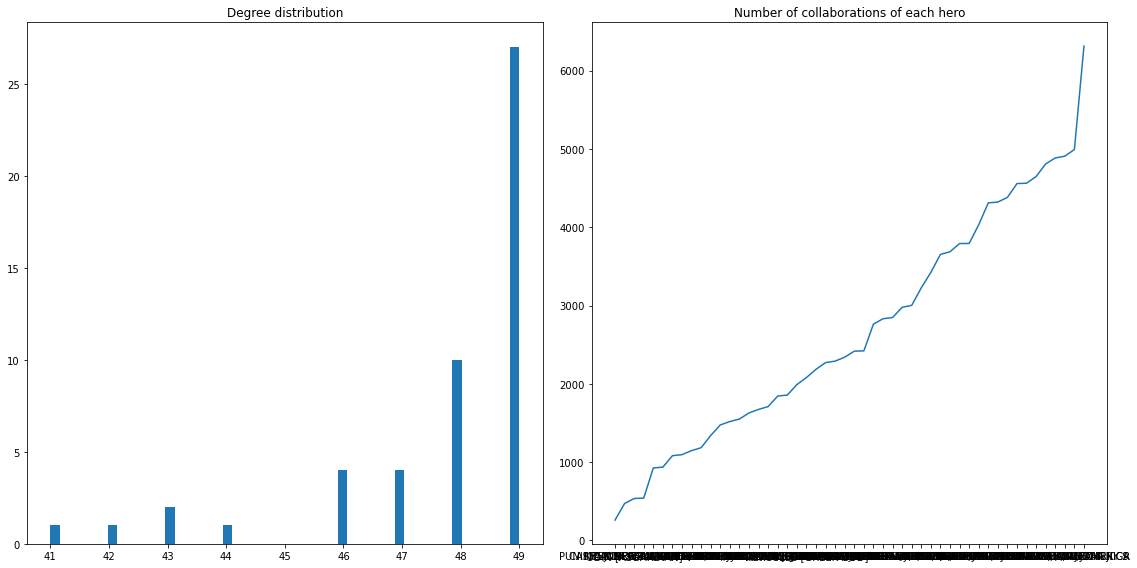

In [268]:
visualize_features()

#### *Example of visualization with graph of type 2*

Enter the dataframe that you want to use: df_edges
Enter the type of graph that you want to build (1 or 2):  2
Enter the number of top heroes to consider:  50


╒════════════════════════════════╤═════════════╤══════════════╤═════════════╕
│ number of nodes                │     density │   avg degree │ is dense?   │
╞════════════════════════════════╪═════════════╪══════════════╪═════════════╡
│ {'comics': 9315, 'heroes': 50} │ 0.000632062 │      5.91863 │ False       │
╘════════════════════════════════╧═════════════╧══════════════╧═════════════╛
Hubs: ['A3 23', 'UX 145', 'HULK/DR. ROBERT BRUC', 'UX 191', 'A 280', 'A 144', 'SMTU 4', 'H2 321', 'MARVELS 3', 'A 167', 'A 221', 'A 8', 'A 21', 'ASM 16', 'TOS 49', 'A 3', 'M/TE 13', "UTSM '97", 'XF 70', 'A 165', 'A 166', 'X 95', 'X 3', 'A 189', 'A 1.5', 'H2 152', 'FF 242', 'A3 43', 'GAL 3', 'A 53', 'A 59', 'N 1/3', 'M/TIO 96', 'A 162', 'STORM/ORORO MUNROE S', 'COLOSSUS II/PETER RA', 'A 156', 'FF 243', 'M/TU 4', 'GAL 2', 'UX 337', 'UX 135', 'SVTU 9', 'CA 401', 'A 157', 'M/SHSW 6', 'CAPTAIN AMERICA', 'NELSON, FRANKLIN FOG', 'GAL 1', 'SUB-MARINER/NAMOR MA', 'M/GN 27', 'A:C', 'A 7', 'QUICKSILVER/PIETRO M', 

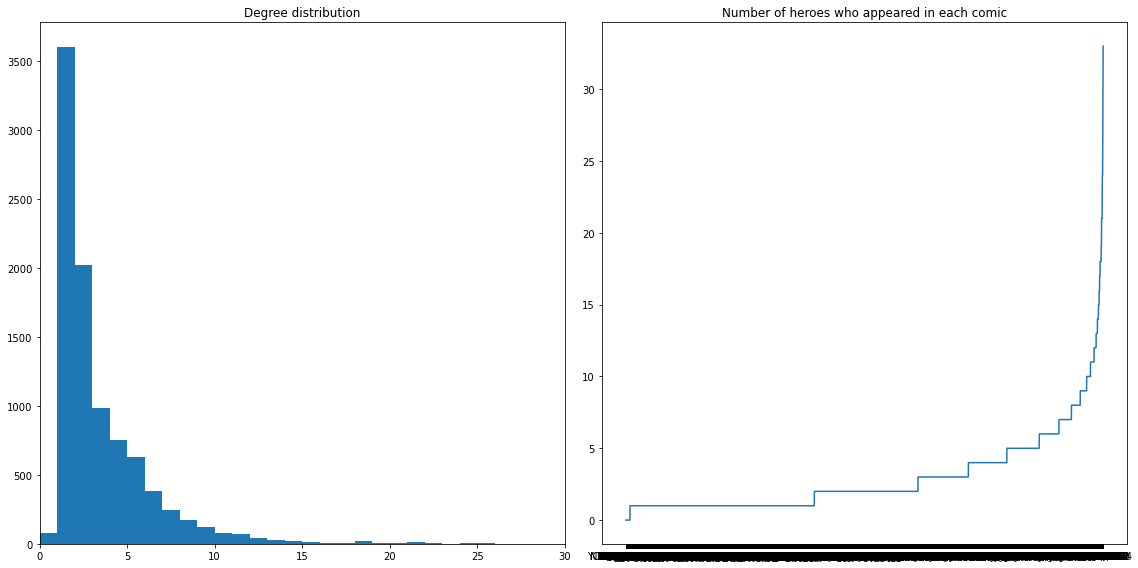

In [269]:
visualize_features()

<br>
<br>

***Comments***: The main information that we can retrieve from the two visualizations are the fact that the graph of type 1 is dense while the graph of type 2 is sparse, and also that the average degree is higher in the case of the graph 1. We can infer that in average each hero has collaborated with a lot of other heroes, while each comic is mainly about only one hero (we can see in the plot that almost 40% of all the comics contain only one hero)

### Visualization 3 - Visualize the shortest-ordered route
We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

* Print the comics in the shortest walk in order
* Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [27]:
def give_order_path(path):
    count = 0
    sub_hero = nx.Graph()
    for i in range(1,len(path)):
        count+=1
        if sub_hero.has_edge(path[i-1],path[i]):
            sub_hero[path[i-1]][path[i]]['peso'] += '-'+str(count)
        else:
            sub_hero.add_edge(path[i-1], path[i], peso=str(count))
    return(sub_hero)

In [28]:
def plot_graph(sub_hero):
    pos = nx.spring_layout(sub_hero,seed=7)  # positions for all nodes - seed for reproducibility
    plt.rcParams["figure.figsize"]=(10,5)
    # nodes
    nx.draw_networkx_nodes(sub_hero, pos,node_color='yellow', node_size=300)

    # edges
    nx.draw_networkx_edges(sub_hero, pos,width=4)
    nx.draw_networkx_edges(sub_hero, pos, width=4, alpha=0.5, edge_color="blue")

    # node labels
    nx.draw_networkx_labels(sub_hero, pos, font_size=10, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(sub_hero, "peso")
    nx.draw_networkx_edge_labels(sub_hero, pos, edge_labels,font_color='red',font_size=15)

    ax = plt.gca()
    ax.margins(0.08)
    #plt.axis("off")
    plt.tight_layout()
    plt.show()

In [29]:
def input_visualization_3():
    graph_data = input("Enter the desidered graph:(In this case only '2' is allowed) ")
    if graph_data=='2':
        graph_data = df_edges
    else:
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    N = int(input("Enter the top N heroes that we should considered: "))
    if(N<0 or N>Graph_2.number_of_nodes()):
        N=Graph_2.number_of_nodes()
    first_N_heroes = Top_N_heroes(N,graph_data)
    init_nodo = input("Enter the initial hero node: ")
    if(init_nodo not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    end_nodo = input("Enter the hero end node: ")
    if(end_nodo not in first_N_heroes):
        raise ValueError("Re-run the cell, input not correct")
        sys.exit()
    seq_heroes = []
    n = int(input("Enter the list size \n"))
    for i in range(0, n):
        print("Enter hero at index", i, )
        hero= input()
        seq_heroes.append(hero)
    print("User list is ", [init_nodo]+seq_heroes+[end_nodo])
    for elem in seq_heroes:
        if elem not in first_N_heroes:
            raise ValueError("Re-run the cell, input not correct")
            sys.exit()
    return(graph_data,seq_heroes,init_nodo,end_nodo,N)

In [30]:
def visualization_3(graph_data,seq_heroes,init_nodo,end_nodo,N):
    first_N_heroes = Top_N_heroes(N,graph_data)
    Shortest_OR,Graph_3 = Shortest_Path_Comics(graph_data,seq_heroes,init_nodo,end_nodo,N)
    print(f'This is the connecting component we have found that start with {init_nodo} and ends at {end_nodo}:\n'
                ,Shortest_OR[1:-1])
    print("If we want to visualize only a walk of comics then: \n",[item for item in Shortest_OR if item not in first_N_heroes])
    sub_hero = give_order_path(Shortest_OR)
    plot_graph(sub_hero)
    return(sub_hero,Graph_3)

### Let's have a test

This is the connecting component we have found that start with SPIDER-MAN/PETER PAR and ends at THOR/DR. DONALD BLAK:
 ['A 11', 'CAPTAIN AMERICA', 'A 1', 'THING/BENJAMIN J. GR', 'A 1.5', 'SPIDER-MAN/PETER PAR', 'A 1.5']
If we want to visualize only a walk of comics then: 
 ['A 11', 'A 1', 'A 1.5', 'A 1.5']


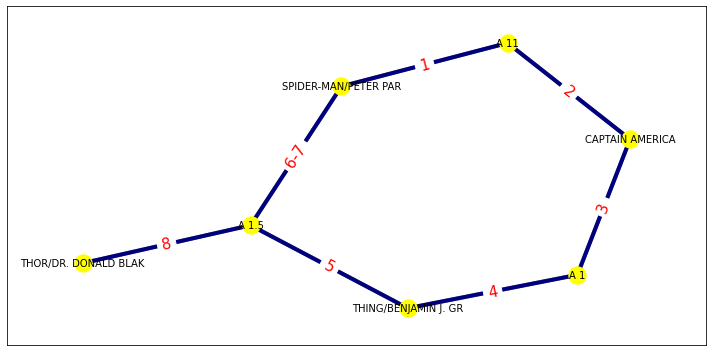

In [31]:
graph_data = df_edges
seq_heroes = ['CAPTAIN AMERICA', 'THING/BENJAMIN J. GR', 'SPIDER-MAN/PETER PAR']
init_nodo = 'SPIDER-MAN/PETER PAR'
end_nodo = 'THOR/DR. DONALD BLAK'
N = 5
sub_hero,Graph_3 = visualization_3(graph_data,seq_heroes,init_nodo,end_nodo,N)

Since even with only a few top heroes considered the graph is full of nodes, having a visualisation with all nodes is really not very indicative.\
We still used a graph visualisation programme called 'gephi'to get an idea of the situation anyway.\
Here we then passed the graph with the partition of the arcs to the programme.\
We gave value 1 to the arcs that were part of the shortest path, 0 otherwise.\
Gephi allowed us to visualise this graph full of nodes and we coloured the arcs belonging to the path.

In [50]:
Graph_3_sub = nx.Graph()
#iterate on all the edges of the multigraph
for u,v in Graph_3.edges:
    if sub_hero.has_edge(u,v):
        Graph_3_sub.add_edge(u, v, peso=1)
    else:
        Graph_3_sub.add_edge(u, v, peso=0)
nx.write_gexf(Graph_3_sub, "sub_hero.gexf")

We can display all the edges in the graph.\
For a better visualisation, we used the 'Yifan Hiu' layout and chose that the size of the node name should be proportional to the number of links.

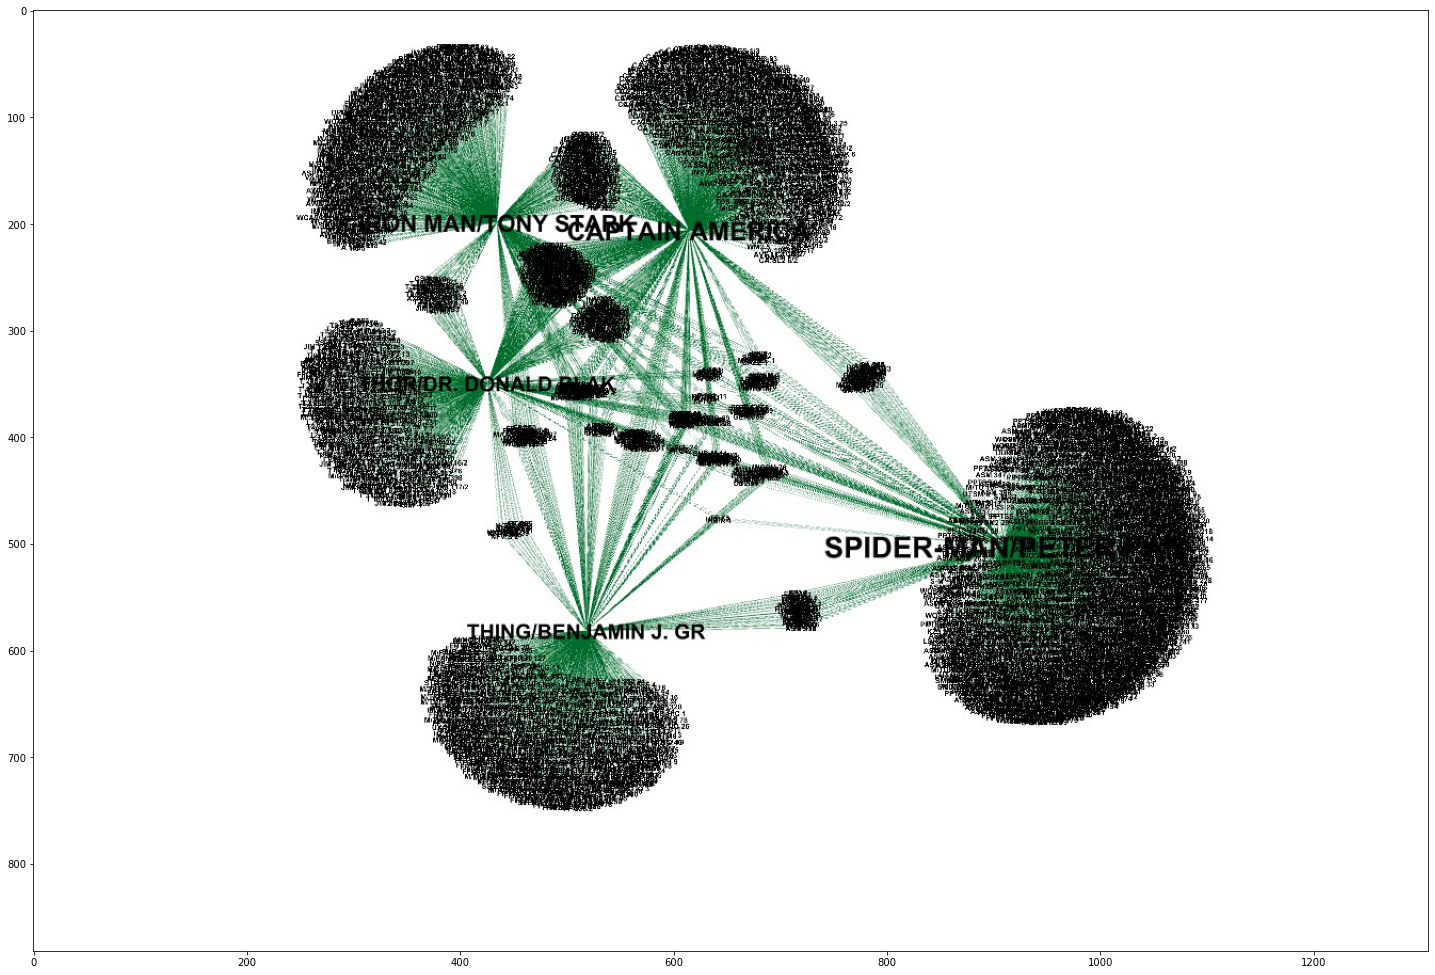

In [77]:
import matplotlib.image as mpimg
image = mpimg.imread("graphplot.jpg")
plt.rcParams["figure.figsize"]=(25,25)
plt.imshow(image)
plt.show()

In red we have the edges that belongs to the path considered before.\
Was impossible to print all the edges and the ones belonging to the shortest path with a different colour,\
 so we choose to display only the ones that belongs to the shortest path.

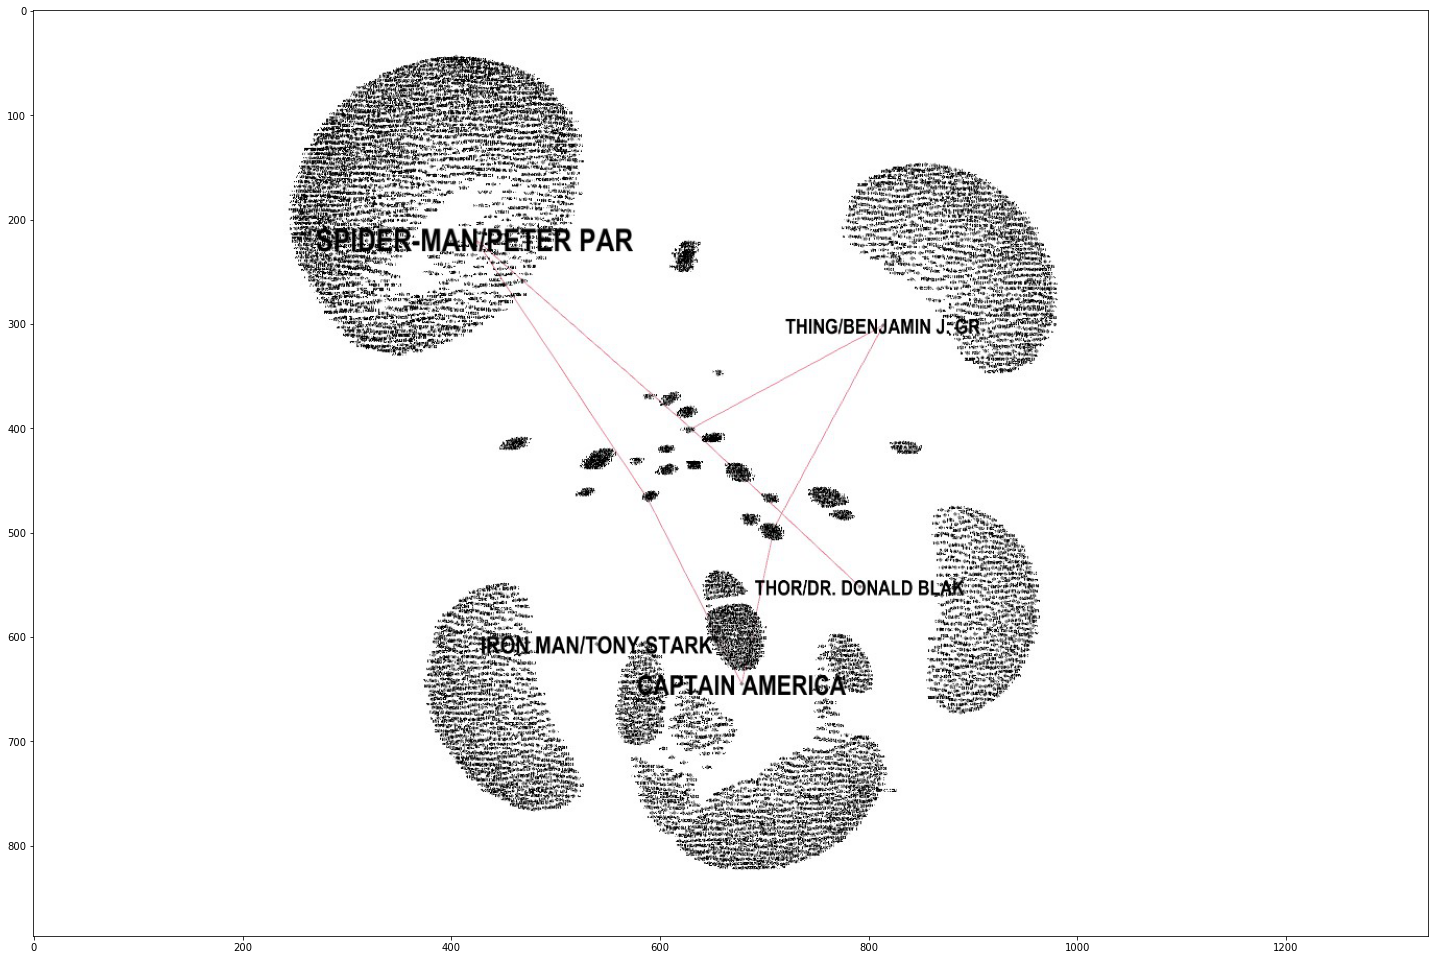

In [81]:
import matplotlib.image as mpimg
image = mpimg.imread("graphplot2.jpg")
plt.rcParams["figure.figsize"]=(25,25)
plt.imshow(image)
plt.show()

### Visualization 4 - Visualize the disconnected graph

* Print the number of the links that should be disconnected
* Plot the original graph
* Plot the graph after removing the links and identify the two nodes

To make the plot of the two graphs easier we ask to the *disconnect_graph()* function to return also the original and the modified graphs.

In [276]:
def visualize_disconnect():
    #get the inputs
    heroA = input('Enter the first hero:')
    heroB = input('Enter the second hero:')
    N = int(input("Enter the number of top heroes to consider: "))
    
    #call the function
    res = disconnect_graph(df_hero_noduplicate, heroA, heroB, N)
    
    #PLOT
    #print number of links to disconnect
    print('Number of links to disconnect (considering the weight):', res[0])
    #print original graph
    plt.figure(1)
    nx.draw(ris[1], with_labels = True)
    #print modified graph
    plt.figure(2)
    nx.draw(ris[2], with_labels = True)

    plt.show()

Enter the first hero: IRON MAN/TONY STARK
Enter the second hero: THING/BENJAMIN J. GR
Enter the number of top heroes to consider:  6


Number of links to disconnect (considering the weight): 0.03607055004195208


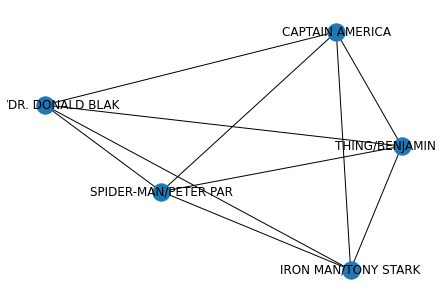

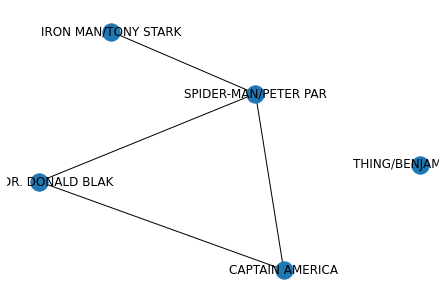

In [277]:
visualize_disconnect()